In [1]:
%load_ext autoreload
%autoreload 2

import hsfm
import hipp

In [2]:
from pathlib import Path
import gdown
import shutil
import pandas as pd

# Multiple Dates - Multiple Blocks

In this example we will process multiple NAGAP image aquisitions taken over the SW corner of Mt Baker, WA. Some image aquisitions at a given date are spatially seperated, but overlap with other image aquisitions collected at other dates.

For more information about multi-temporal processesing see https://doi.org/10.1016/j.rse.2022.113379. Note that the term "pseudofiducial marker" is synonomous with "fiducial marker proxy" used in the code.

## Preprocess NAGAP imagery
The nagap_image_metadata.csv file has been compiled from NAGAP metadata files available at www.arcticdata.io. The file contains all images for which a tif image url is available in the original metadata. 

The routine below will download and preprocess all NAGAP images that fall within the defined spatial bounds. Pseudofiducial marker templates that correspond to each image are indexed in the nagap_image_metadata.csv file. 

See [this example](https://github.com/friedrichknuth/hipp/blob/master/examples/fiducial_proxy_detection/nagap_imagery.ipynb) on how to create new marker templates.

#### Notes
- Use `tail -f path/to/preprocessing.log` from the terminal to watch the preprocessing log
- Examine the folder structure generated by `hsfm.batch.NAGAP_pre_process_images` by running `tree` from your command line

In [3]:
bounds= (-121.89, 48.787, -121.81, 48.73) ## approximate bounds for SW corner of Mt Baker
nagap_metadata_csv = 'https://github.com/friedrichknuth/hipp/raw/master/examples/fiducial_proxy_detection/input_data/nagap_image_metadata.csv'
template_parent_dir = '../../src/hipp/examples/fiducial_proxy_detection/input_data/fiducials/nagap'
project_name = 'easton_NAGAP'
out_dir      = 'multi_date_multi_block_example'
dates = ['1970-09-29', '1977-09-27', '1979-10-06', '1991-09-09']

#### Optionally check bounds on map

In [4]:
# m = hsfm.geospatial.select_features_on_map(hsfm.geospatial.bounds2polygon(*bounds, 
#                                                                       crs='epsg:4236'))
# m

#### Preprocess images

In [5]:
log_fn = Path(out_dir, project_name, 'preprocessing_log.log')
errors_fn = Path(out_dir, project_name, 'preprocessing_errors.log')

with hsfm.io.redirect_stdout_stderr(log_fn, errors_fn):
    for date in dates:
        year, month, day = date.split('-')
        hsfm.batch.NAGAP_pre_process_images(project_name,
                                            bounds,
                                            year = year[2:],
                                            month = month,
                                            day = day,
                                            nagap_metadata_csv=nagap_metadata_csv,
                                            template_parent_dir = template_parent_dir,
                                            output_directory=out_dir,
                                           )
    print('DONE')

#### Parse the log for warnings

In [6]:
# !cat {log_fn} | grep -A 7 WARNING

#### Examine the file structure created and expected for batch SfM processing steps

In [7]:
# !tree {out_dir}

### Check all images have consistent dimensions
If images don't have consistent dimensions, Metashape will treat each set as a seperate camera model.

In [8]:
problematic_image_dirs, df = hsfm.core.check_image_dims(out_dir, project_name,)
df

date  image_count image_square_dims          roll
0  [1970-09-29]           21           [10960]  [NAGAP_70V2]
1  [1977-09-27]           45           [11292]  [NAGAP_77V6]
2  [1979-10-06]           19           [11266]  [NAGAP_79V6]
3  [1991-09-09]           22           [11270]  [NAGAP_91V3]

## Download USGS 3DEP reference DSM

In [9]:
reference_dem = Path('reference_dems','baker_reference_DSM.tif').as_posix()
# reference_dem.parent.mkdir(parents=True, exist_ok=True)
# gdown.download(id='1ObQyjhYB_fjhvqtBq-vK3CdPoQ1Iauyd', 
#                output=reference_dem, 
#                quiet=False)

## Create 4D SfM metadata
Combine all image metadata csv files into a single file for joint SfM processing and camera model optimization.  
Rename the input csv files so that they won't be detected during this optimization step.

In [10]:
hsfm.metashape.combine_metadata_for_4D_SfM(out_dir,
                                           project_name,
                                           rename_input_csvs = True,
                                           pattern='.csv',
                                           new_pattern='_initial.csv',
                                          )

## 4D SfM camera optimization

The batch_process routine will find all metadata csv files that match the following pattern:

`out_dir/project_name/input_data/*/*/*/sfm/cluster_*/metashape_metadata.csv`

In this case, there should only be one file found and processed, which is the combined metadata file we just created.

#### Note:
- All stdout will appear in the log files, except Metashape stdout.
- Use `tail -f path/to/sfm_processing_log.log` from the terminal to watch the log
- Note that `check_subsets = False` because we are primarily concearned with a join intrinsic camera model optimization and not spatially seperating blocks at this step

In [11]:
image_matching_accuracy = 1
densecloud_quality      = 2
metashape_licence_file  = '/mnt/working/knuth/sw/metashape-pro/uw_agisoft.lic'

In [39]:
log_fn = Path(out_dir, project_name, 'sfm_4D_processing_log.log')
errors_fn = Path(out_dir, project_name, 'sfm_4D_processing_errors.log')

with hsfm.io.redirect_stdout_stderr(log_fn, 
                                    errors_fn):
    hsfm.batch.batch_process(project_name,
                             reference_dem,
                             input_directory         = out_dir,
                             image_matching_accuracy = image_matching_accuracy,
                             densecloud_quality      = densecloud_quality,
                             metashape_licence_file  = metashape_licence_file,
                             check_subsets           = False,
                             overwrite               = False,
                            )
    print('DONE')

## Quick check 4D SfM result
- Examine the dem_align.py qc plot to check that the multitemporal composite DEM was coregistered correctly
- A reasonable result indicates the cameras positions are corrected from their initial positions

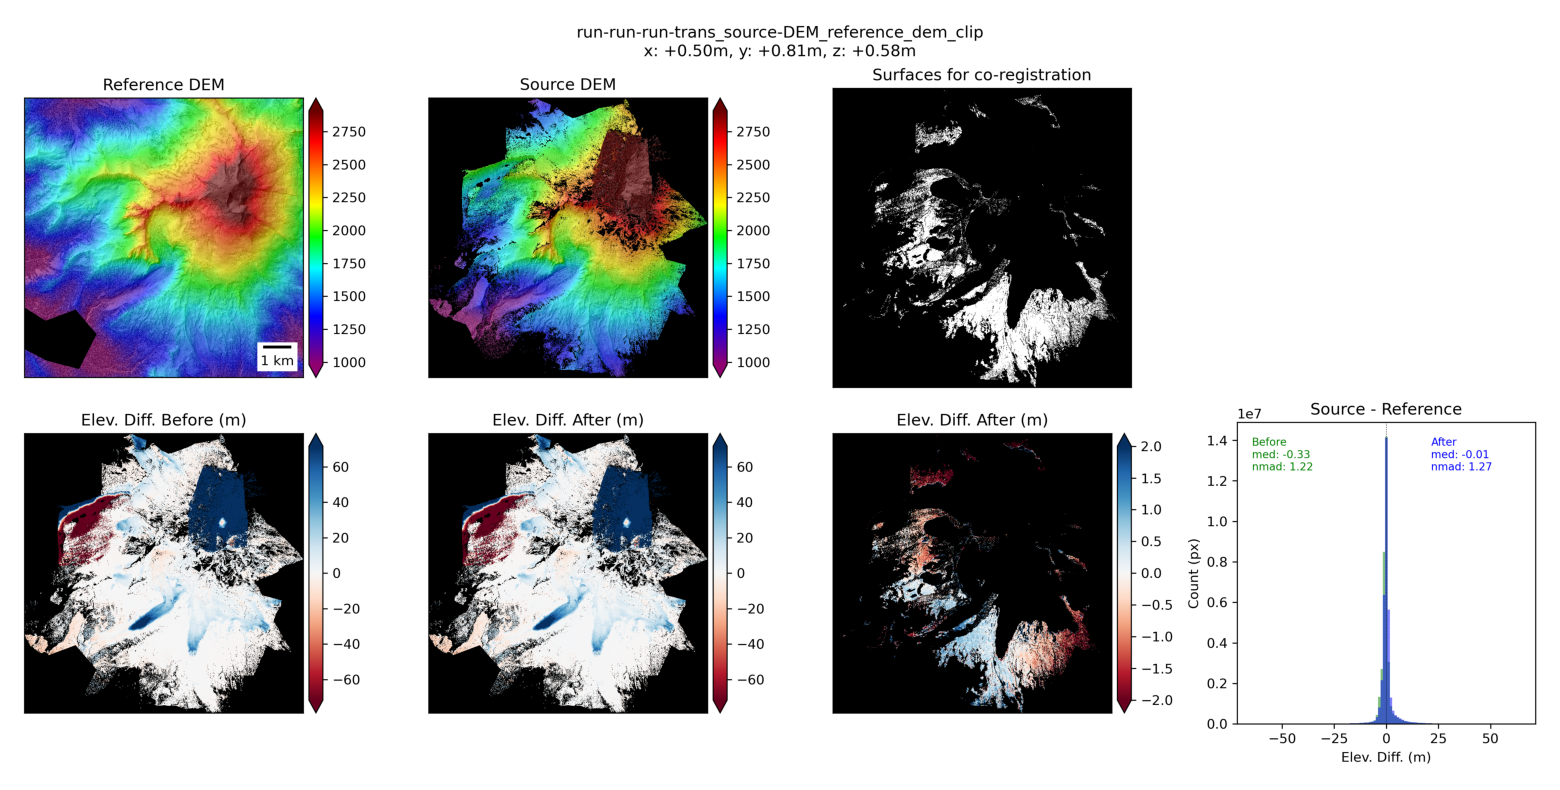

In [13]:
img = sorted(Path(out_dir,project_name).glob('**/0000/**/*align.png'))[0]
hsfm.plot.plot_image_from_file(img)

## Rename 4D SfM metadata
So that it doesn't get picked up later and used again during batch processing

In [14]:
multi_temporal_csv = sorted(Path(out_dir,project_name).glob('**/0000/**/*metashape_metadata.csv'))

hsfm.metashape.rename_files(multi_temporal_csv,
                            pattern='.csv',
                            new_pattern='_initial.csv')

## Update camera position metadata

In [15]:
updated_cameras_csv = sorted(Path(out_dir,
                                  project_name).glob('**/0000/**/aligned_bundle_adjusted_metadata.csv'))[0]

inital_cameras_csvs = sorted(Path(out_dir,
                                  project_name).glob('input_data/[!0]*/**/metashape_metadata_initial.csv'))

In [16]:
hsfm.metashape.update_camera_postion_metadata_after_4D_SfM(updated_cameras_csv,
                                                inital_cameras_csvs,
                                                pattern = '_initial.csv',
                                                new_pattern='_4D.csv',
                                                verbose = True)

## Export 4D SfM camera models
The batch processing routine will look for .xml camera models in the directory below. These camera models specify the optimized intrinsic camera model parameters.

In [17]:
metashape_4D_SfM_project_file = sorted(Path(out_dir, project_name).glob('**/0000/**/*.psx'))[0]

In [18]:
camera_models_dir = Path(out_dir,project_name,'input_data','camera_models')

In [19]:
hsfm.metashape.export_camera_models(metashape_4D_SfM_project_file,
                                    camera_models_dir,
                                    verbose=True)

## Stage 4D SfM updated metadata csv files 
- These contain the updated camera positions
- We rename them so they will be used during single timestamp - single block processing

In [20]:
updated_cameras_csvs = sorted(Path(out_dir,
                                    project_name).glob('**/*4D.csv'))

In [21]:
hsfm.metashape.rename_files(updated_cameras_csvs,
                            pattern = '_4D.csv',
                            new_pattern='.csv',
                            copy=True)

## Process single date - single blocks

In [22]:
log_fn = Path(out_dir, project_name, 'sfm_processing_log.log')
errors_fn = Path(out_dir, project_name, 'sfm_processing_errors.log')

with hsfm.io.redirect_stdout_stderr(log_fn, 
                                    errors_fn):
    hsfm.batch.batch_process(project_name,
                             reference_dem,
                             input_directory         = out_dir,
                             image_matching_accuracy = image_matching_accuracy,
                             densecloud_quality      = densecloud_quality,
                             metashape_licence_file  = metashape_licence_file,
                             check_subsets           = True,
                             overwrite               = False,
                            )
    print('DONE')

## Examine coregistration QC plots

#### Notes:
- We skip the qc plot from the multi-temporal composite DEM coregistration
- The first returned QC plot is also skipped
  - It belongs to the 1970-09-29 blocks
  - These cameras all have the same starting location and those that belong to this first block failed to be corrected during multi-temporal bundle adjustment
- The remaining blocks were all successfully coregistered to the reference terrain.

9


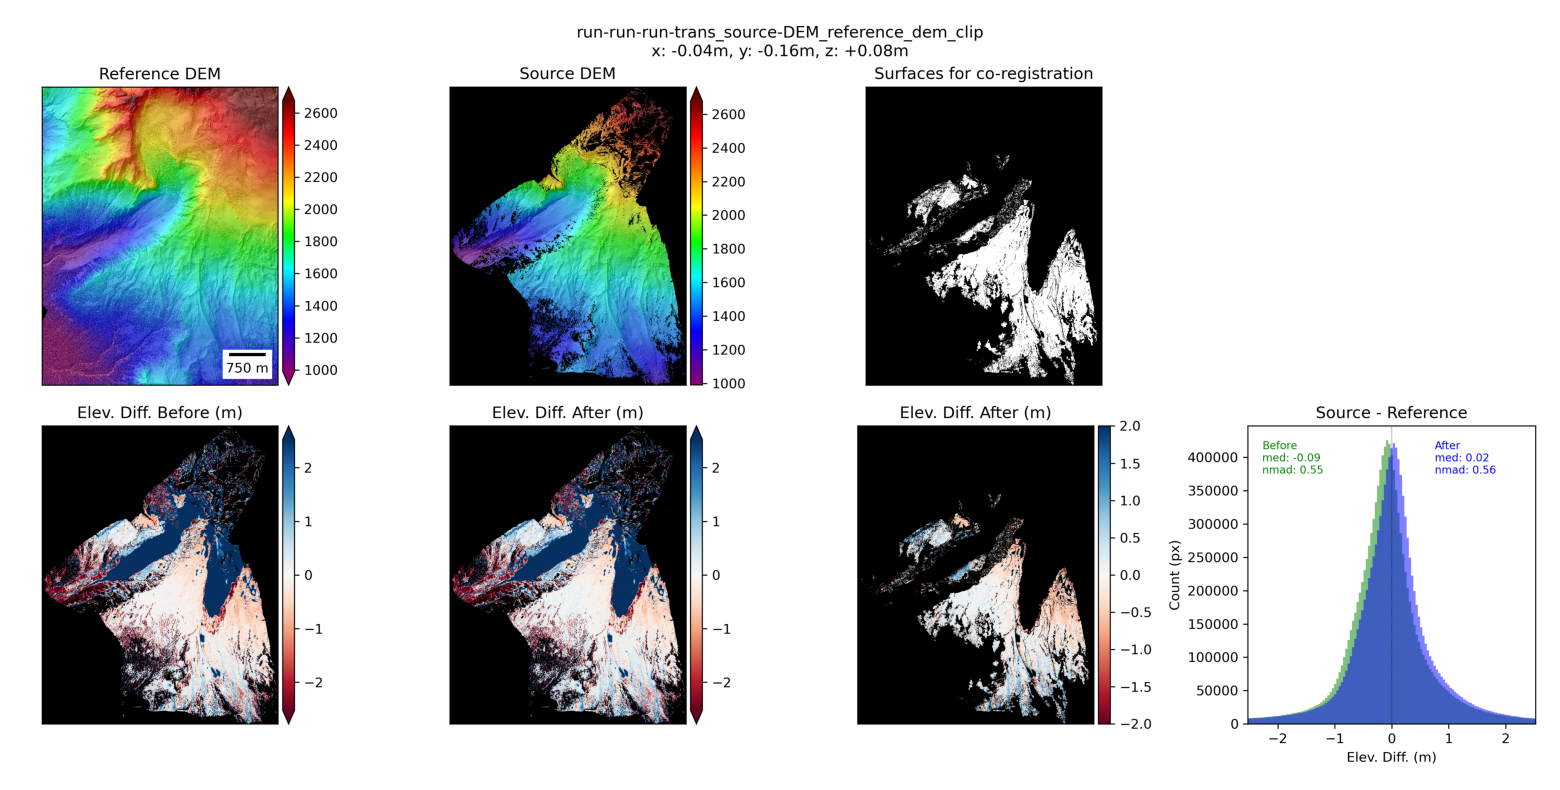

In [23]:
i = 0
qc_imgs = sorted(Path(out_dir, project_name).glob('*/[!0]*/**/*align.png'))[1:]
print(len(qc_imgs))
hsfm.plot.plot_image_from_file(qc_imgs[i])

## Generate orthoimages

In [26]:
dem_file_paths = sorted(Path(out_dir, project_name).glob('*/[!0]*/**/*align.tif'))[1:]
project_files = [Path(list(Path(x).parent.parent.parent.glob('*.psx'))[0]) for x in dem_file_paths]
icp_aligned_metadata_csv_files = [Path(x.parent.parent.parent, 'aligned_bundle_adjusted_metadata.csv') for x in dem_file_paths]
nuth_and_kaab_json_files = [Path(x.as_posix().replace('align.tif', 'align_stats.json')) for x in dem_file_paths]
epsg_code = hsfm.geospatial.get_epsg_code(reference_dem)

In [27]:
[len(dem_file_paths) == len(x) for x in [project_files, 
                                         icp_aligned_metadata_csv_files, 
                                         nuth_and_kaab_json_files,]]

[True, True, True]

#### Update the camera positions with Nuth and Kääb transform

In [28]:
updated_camera_positions_csvs = []
for i,v in enumerate(icp_aligned_metadata_csv_files):
    out = hsfm.core.update_cameras_post_icp(icp_aligned_metadata_csv_files[i],
                            nuth_and_kaab_json_files[i],
                            epsg_code = epsg_code,
                           )
    updated_camera_positions_csvs.append(out)

#### Update the final camera positions in the Metashape project

In [29]:
for i,v in enumerate(updated_camera_positions_csvs):
    hsfm.metashape.update_metashape_cameras_after_transform(project_files[i].as_posix(),
                                                            v.as_posix())

#### Export the orthoimage mosaics

In [30]:
ortho_files = []
for project_file in project_files:
    ortho_file = hsfm.metashape.images2ortho(project_file.as_posix(),
                                             epsg_code       = epsg_code,
                                             cleanup         = True,
                                             verbose         = True)
    ortho_files.append(ortho_file)

## Gather final outputs

In [31]:
final_products_dir = Path(out_dir, project_name, 'final_outputs')
final_products_dir.mkdir(parents=True, exist_ok=True)

In [32]:
final_dems                    = dem_file_paths
final_orthos                  = [Path(list(Path(x).parent.parent.parent.glob('*ortho*.tif'))[0]) for x in final_dems]
metashape_reports             = [Path(list(Path(x).parent.parent.parent.glob('*report.pdf'))[0]) for x in final_dems]
coreg_qc_plots                = [x.with_suffix('.png') for x in final_dems]
initial_camera_positions_csvs = [Path(x.parent.parent.parent.parent, 'metashape_metadata.csv') for x in final_dems]
final_camera_positions_csvs   = [Path(x.parent.parent.parent, 'coreg_aligned_bundle_adjusted_metadata.csv') for x in final_dems]

In [33]:
[len(final_dems) == len(x) for x in [final_dems, 
                                    final_orthos, 
                                    metashape_reports, 
                                    coreg_qc_plots, 
                                    initial_camera_positions_csvs,
                                    final_camera_positions_csvs]]

[True, True, True, True, True, True]

In [34]:
for i,v in enumerate(final_dems):
    date_string = v.as_posix().split('input_data/')[-1].split('/sfm')[0].replace('/','-')
    date_string ='19' + date_string.split('V')[0] + date_string.split('V')[-1][1:]
    if '/metashape/' in v.as_posix():
        block_id = dem_file_paths[i].as_posix().split('/metashape0/')[0].split('/metashape/')[-1]
    else:
        block_id = ''
    outdir = Path(final_products_dir, date_string+'_'+block_id)
    outdir.mkdir(parents=True, exist_ok=True)
    shutil.copy2(final_dems[i], Path(outdir, 'dem.tif'))
    shutil.copy2(final_orthos[i], Path(outdir, 'ortho.tif'))
    shutil.copy2(metashape_reports[i], Path(outdir, 'metashape_report.pdf'))
    shutil.copy2(coreg_qc_plots[i], Path(outdir, 'coreg_qc_plot.png'))
    shutil.copy2(initial_camera_positions_csvs[i], Path(outdir, 'initial_camera_positions.csv'))
    shutil.copy2(final_camera_positions_csvs[i], Path(outdir, 'final_camera_positions.csv'))

In [36]:
!tree {final_products_dir}

multi_date_multi_block_example/easton_NAGAP/final_outputs
├── 1970-09-29_sub_cluster1
│   ├── coreg_qc_plot.png
│   ├── dem.tif
│   ├── final_camera_positions.csv
│   ├── initial_camera_positions.csv
│   ├── metashape_report.pdf
│   └── ortho.tif
├── 1970-09-29_sub_cluster2
│   ├── coreg_qc_plot.png
│   ├── dem.tif
│   ├── final_camera_positions.csv
│   ├── initial_camera_positions.csv
│   ├── metashape_report.pdf
│   └── ortho.tif
├── 1977-09-27_sub_cluster0
│   ├── coreg_qc_plot.png
│   ├── dem.tif
│   ├── final_camera_positions.csv
│   ├── initial_camera_positions.csv
│   ├── metashape_report.pdf
│   └── ortho.tif
├── 1977-09-27_sub_cluster1
│   ├── coreg_qc_plot.png
│   ├── dem.tif
│   ├── final_camera_positions.csv
│   ├── initial_camera_positions.csv
│   ├── metashape_report.pdf
│   └── ortho.tif
├── 1977-09-27_unaligned_subset
│   ├── coreg_qc_plot.png
│   ├── dem.tif
│   ├── final_camera_positions.csv
│   ├── initial_camera_positions.csv
│   ├── metashape_report.pdf
│   └── ort